## MNIST
- Dropout, Augmentation 적용 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


False cpu


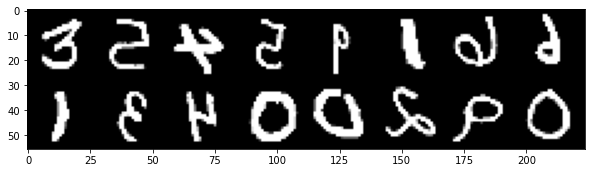

tensor([3, 5, 4, 5, 9, 1, 6, 6, 1, 3, 4, 0, 0, 2, 9, 0])


In [7]:
from torchvision import datasets, transforms, utils
from torch.utils import data

import matplotlib.pyplot as plt
import numpy as np

# MNIST Classes

# 단계1) transform 설정 (이미지 로드시 변환 도구)
# 단계2) train, test data 설정 및 transform 객체 연결
# 단계3) 데이터 로더 준비 (batch size 설정)
batch_size = 16

train_loader = data.DataLoader(
    dataset = datasets.MNIST(
        root = 'data/', 
        train = True, 
        download = True, # 데이터셋 다운로드
        transform = transforms.Compose([
            transforms.ToTensor(), # 이미지를 파이토치 텐서로 변환
            transforms.Normalize((0.1307, ), (0.3081,)) ,
            transforms.RandomHorizontalFlip() #무작위 오른쪽 왼쪽 뒤집기
        ])
    ),
    batch_size = batch_size,
    shuffle = True
)

test_loader = data.DataLoader(
    dataset = datasets.MNIST(
        root = 'data/',
        train = False,
        download = True,
        transform = transforms.Compose([
            transforms.ToTensor(), # 이미지를 파이토치 텐서로 변환
            transforms.Normalize((0.1307, ), (0.3081,)) 
        ])
    ),
    batch_size = batch_size
)

# 단계4) data 가져오기, for문 사용가능, iter사용가능
dataiter = iter(train_loader)
images, labels = next(dataiter)

# visualiztaion
def visualization(images, labels):
    # utils의 makergrid 함수로 grid 만들어주기
    img = utils.make_grid(images, padding=0) # 가져온 image들 grid 형태로 만들어줌
    npimg = img.numpy()
    plt.figure(figsize=(10,7))
    plt.imshow(np.transpose(npimg, (1,2,0))) # matplotlib 호환을 위한 tranpose
    plt.show()
    
# image 시각화해보기
visualization(images, labels)
print(labels)


## MNIST로 손글씨 숫자 분류하기

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # nn 모듈의 함수 버전
from torchvision import transforms, datasets # torchvision dataset 다루기 위한

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(USE_CUDA, DEVICE)

epochs = 30
batch_size = 64

## 모델 설계
# fc layer1 : 784 -> 256 
# fc layer2 : 256 -> 128
# fc layer3 : 128 -> 10

class Net(nn.Module):
    def __init__(self, dropout_p = 0.2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
        # 드롭아웃 확률
        self.dropout_p = dropout_p
        
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training, p=self.dropout_p)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training = self.training, p=self.dropout_p)
        x = self.fc3(x)
        return x

    
# 학습 함수
def train(model, train_loader, optimizer):
    model.train()

    for batch_idx, (data,target) in enumerate(train_loader):
        # 학습 데이터를 DEVICE의 메모리로 보냄
        data, target = data.to(DEVICE), target.to(DEVICE)

        # 반복 때마다 기울기를 새로 계산하므로, optimizer.zero_grad() 함수 호출
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step() # step() 함수는 계산한 기울기를 앞서 정의한 알고리즘에 맞추어 가중치를 수정
    
    
# 평가때는 기울기를 계산하지 않음
def evaluate(model, test_loader):
    model.eval() # 평가 모드로 모델 변경
    test_loss = 0 # 테스트 오차
    correct=0 # 예측이 맞은 수
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE) # test data, target DEVICE 로 전송
            output = model(data) 
            
            # 교차엔트로피시 미니배치의 합을 받아와야 함.
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # item() 함수 - 1개의 값을 가진 텐서의 값을 가져옴
        
            pred = output.max(1, keepdim=True)[1] # 가장 큰 확률 값을 가진 값 예측 -> 가장 큰 값과, 해당 값의 index 반환 -> index 사용
            correct += pred.eq(target.view_as(pred)).sum().item() # view_as => target을 pred의 shape처럼 바꿔줌 / sum().item() => 맞춘갯수의 합

    # 정확도 구하기
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, test_accuracy 
        

False cpu


In [16]:
# to 함수는 모델의 파라미터들을 지정한 장치의 메모리로 보냄
model = Net(dropout_p = 0.2).to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01)


# 실제 학습 진행
for epoch in range(1, epochs+1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, test_loss, test_accuracy))

[1] Test Loss: 0.3102, Accuracy: 90.35%
[2] Test Loss: 0.2082, Accuracy: 93.55%
[3] Test Loss: 0.1681, Accuracy: 94.65%
[4] Test Loss: 0.1473, Accuracy: 95.53%
[5] Test Loss: 0.1288, Accuracy: 96.00%
[6] Test Loss: 0.1219, Accuracy: 96.08%
[7] Test Loss: 0.1193, Accuracy: 96.18%
[8] Test Loss: 0.1084, Accuracy: 96.61%
[9] Test Loss: 0.1040, Accuracy: 96.63%
[10] Test Loss: 0.0982, Accuracy: 96.87%
[11] Test Loss: 0.0974, Accuracy: 96.93%
[12] Test Loss: 0.0906, Accuracy: 97.27%
[13] Test Loss: 0.0924, Accuracy: 97.24%
[14] Test Loss: 0.0909, Accuracy: 96.93%
[15] Test Loss: 0.0917, Accuracy: 97.17%
[16] Test Loss: 0.0880, Accuracy: 97.17%
[17] Test Loss: 0.0846, Accuracy: 97.30%
[18] Test Loss: 0.0856, Accuracy: 97.26%
[19] Test Loss: 0.0865, Accuracy: 97.34%
[20] Test Loss: 0.0813, Accuracy: 97.45%
[21] Test Loss: 0.0850, Accuracy: 97.27%
[22] Test Loss: 0.0844, Accuracy: 97.38%
[23] Test Loss: 0.0792, Accuracy: 97.63%
[24] Test Loss: 0.0836, Accuracy: 97.39%
[25] Test Loss: 0.0783, A

In [17]:
from torchsummary import summary
summary(model, (1, 784))
#print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
            Linear-2                  [-1, 128]          32,896
            Linear-3                   [-1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.90
Estimated Total Size (MB): 0.90
----------------------------------------------------------------
